## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-labelling", port=27018)
db = client["hatespeech-labelling"]

In [2]:
db.article.count()

/home/jmperez/.local/share/virtualenvs/hatespeech-labelling-i4Bxdr6F/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


55110

In [3]:
db.article.count_documents({"comments.19": {"$exists": True}})

6519

In [4]:

initial_query = {
    "comments.19": {"$exists": True}
}
articles = db.article.find(initial_query)
articles = list(articles)

print(len(articles))


6519


In [5]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


In [6]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [8]:
import spacy

nlp = spacy.load("es", disable=["parser", "ner"])

l = list(nlp("Hola viejas de re mil mierdas, las odio profundamente desde mi corazón"))

lemmatized = [t.lemma_ for t in l]

In [9]:
from tqdm.auto import tqdm

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


In [10]:
import string

def filter_words(text):
    non_stop = [tok for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if tok not in string.punctuation and "\n" not in tok]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 2), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 4), (45, 4), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 5), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 4), (69, 1), (70, 12), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 4), (98, 1), (99, 1), (100, 1), (101, 1), (102, 8), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 3), (110, 1

In [33]:
import gensim

num_topics = range(2, 40, 2)
# Build LDA model

lda_models = {}
coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [34]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [38]:
import pickle

with open("topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [39]:
Y = [k.get_coherence() for k in coherence_models.values()]

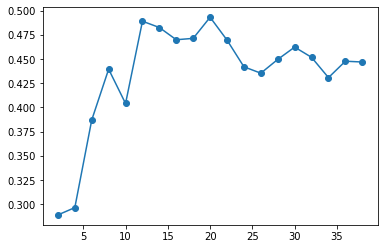

In [40]:
import matplotlib.pyplot as plt

plt.plot([k for k in coherence_models], Y, marker="o")

In [41]:
lda_model = lda_models[20]

In [42]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.045*"empresa" + 0.043*"millón" + 0.029*"pagar" + 0.022*"dólar" + '
  '0.019*"deuda" + 0.016*"año" + 0.016*"peso" + 0.015*"sector" + '
  '0.015*"social" + 0.014*"banco"'),
 (1,
  '0.126*"tinelli" + 0.108*"marcelo" + 0.039*"guillermina" + 0.024*"valdés" + '
  '0.020*"cande" + 0.017*"showmatch" + 0.016*"patagonia" + 0.014*"conductor" + '
  '0.010*"candelaria" + 0.010*"valdes"'),
 (2,
  '0.012*"parir" + 0.012*"gustar" + 0.011*"fuente" + 0.009*"twitter" + '
  '0.009*"2020" + 0.009*"según" + 0.009*"ser" + 0.008*"seguridad" + '
  '0.008*"comentar" + 0.008*"facebook"'),
 (3,
  '0.037*"provincia" + 0.029*"buenos" + 0.029*"aires" + 0.022*"ciudad" + '
  '0.020*"kicillof" + 0.017*"bonaerense" + 0.016*"gobernador" + '
  '0.015*"cuarentena" + 0.015*"ministro" + 0.012*"axel"'),
 (4,
  '0.053*"intendente" + 0.046*"malvinas" + 0.031*"quilmes" + 0.018*"zamora" + '
  '0.017*"test" + 0.017*"lomas" + 0.015*"nazarena" + 0.015*"rioja" + '
  '0.013*"isleño" + 0.012*"menem"'),
 (5,
  '0.063*"médico" 

In [43]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [44]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.070975 -0.329452       1        1  26.694376
9      0.184455 -0.329138       2        1  18.594304
12     0.104897 -0.437778       3        1  15.325511
2     -0.116866 -0.395464       4        1  10.976045
16     0.343677 -0.268731       5        1   6.379011
3     -0.120195 -0.254924       6        1   5.693049
8     -0.300870 -0.259168       7        1   4.677330
13     0.497382  0.074674       8        1   3.129475
0      0.367163  0.219333       9        1   3.050712
5     -0.338668 -0.098656      10        1   2.722138
7      0.300118 -0.017562      11        1   1.724664
4     -0.067504  0.351401      12        1   0.350574
15     0.083176  0.286975      13        1   0.323240
10    -0.251053  0.193789      14        1   0.113986
1     -0.041378  0.239604      15        1   0.097504
11    -0.174710  0.248211      16        1   0.083217
6     -0.166408  0.179507      17        1   0.061466
18    -0.124731  0.199126      18        1   0.001152
14    -0.124731  0.199126      19        1   0.001125
19    -0.124731  0.199126      20        1   0.001121, topic_info=              Term          Freq         Total Category  logprob  loglift
271              “  15858.000000  15858.000000  Default  30.0000  30.0000
272              ”  15663.000000  15663.000000  Default  29.0000  29.0000
238            ser  43446.000000  43446.000000  Default  28.0000  28.0000
250          tener  15558.000000  15558.000000  Default  27.0000  27.0000
789         médico   2366.000000   2366.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
14318  sintiéndose      0.000344      0.883876  Topic20 -10.6663   3.5464
14317     lavallol      0.000344      0.883878  Topic20 -10.6663   3.5464
14316      jessica      0.000344      0.883876  Topic20 -10.6663   3.5464
14315  constatarse      0.000344      0.883876  Topic20 -10.6663   3.5464
14314     amaneció      0.000344      0.883876  Topic20 -10.6663   3.5464

[1164 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2470     12  0.983178      -a
3269      3  0.993928     -no
3518      3  0.982046   -pero
4137      3  0.982153     -yo
3524      3  0.982981  -¿cómo
...     ...       ...     ...
271       8  0.999945       “
272       8  0.999918       ”
458       3  0.260207       •
458       4  0.738926       •
2233      2  0.996004       …

[1896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 10, 13, 3, 17, 4, 9, 14, 1, 6, 8, 5, 16, 11, 2, 12, 7, 19, 15, 20])

In [27]:
len(corpus), len(hateful_articles)

(3399, 3399)

'Los contagios confirmados por dengue superan los 41 mil y 2020 ya tiene el mayor número de casos de la historia'

In [32]:
num = 3


hateful_articles[num]["title"], lda_model.get_document_topics(corpus[num])

('Brasil se encamina a la tormenta perfecta: coronavirus, influenza, dengue y sarampión',
 [(0, 0.1335846),
  (2, 0.0636095),
  (3, 0.019670906),
  (5, 0.07332805),
  (7, 0.32415065),
  (8, 0.19722593),
  (9, 0.064547546),
  (12, 0.0800132),
  (13, 0.036103792)])